In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [3]:
# read in csv to be used for model
data = pd.read_csv('data/new_country_data.csv')
data = data.dropna()

In [4]:
# Assign the data to x and y 
X = data[['happiness_score_2015','human_development_index','gdp_percapita_2015','alcohol_consumption_percapita',\
         'health_spending_percapita_2015','private_debt_2015']]
y = data['sui_per_100k_2015'].values.reshape(-1,1)
print(X.shape,y.shape)

(111, 6) (111, 1)


In [5]:
# drop all unneccesary columns
dataset = data[['sui_per_100k_2015','happiness_score_2015','human_development_index','gdp_percapita_2015','alcohol_consumption_percapita',\
         'health_spending_percapita_2015','private_debt_2015']]
dataset.head()

,sui_per_100k_2015,happiness_score_2015,human_development_index,gdp_percapita_2015,alcohol_consumption_percapita,health_spending_percapita_2015,private_debt_2015
0,6.6,3.58,0.46,578.47,0.2,58.91,3.70
1,5.3,4.96,0.73,3952.83,7.5,192.89,44.54
2,3.4,5.60,0.74,4177.89,0.9,291.55,21.26
3,8.7,6.57,0.84,13789.06,9.8,1531.48,18.70
4,12.2,7.28,0.94,56748.42,10.6,4860.37,199.47


In [6]:
# split the data into train and test
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

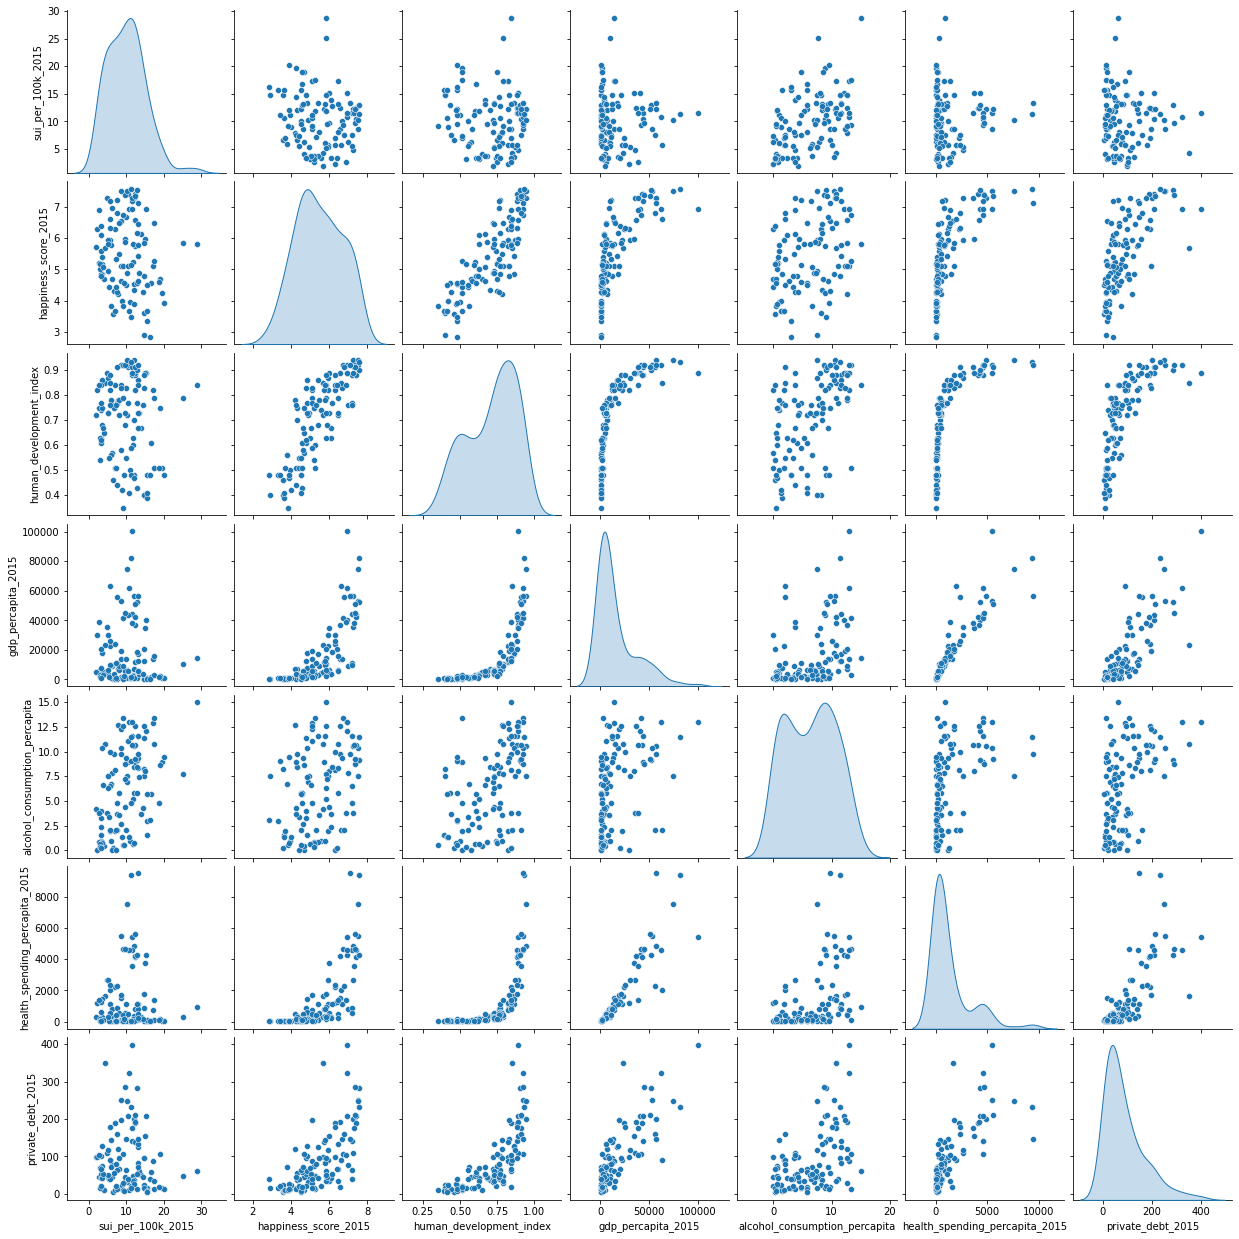

In [7]:
# inspect the data
sns.pairplot(dataset[['sui_per_100k_2015','happiness_score_2015','human_development_index','gdp_percapita_2015','alcohol_consumption_percapita',\
         'health_spending_percapita_2015','private_debt_2015']], diag_kind='kde')

In [8]:
# look at overall statistics
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sui_per_100k_2015,111.0,10.042342,5.027082,2.00,6.000,10.00,13.000,28.80
happiness_score_2015,111.0,5.473423,1.208934,2.84,4.570,5.33,6.470,7.59
human_development_index,111.0,0.710811,0.164135,0.35,0.575,0.75,0.840,0.94
gdp_percapita_2015,111.0,15982.017568,20600.966332,305.55,1525.340,6175.88,21788.230,100428.37
alcohol_consumption_percapita,111.0,6.381081,4.201742,0.00,2.200,6.70,9.800,15.00
health_spending_percapita_2015,111.0,1313.155045,1980.498880,19.46,89.710,389.38,1491.775,9491.09
private_debt_2015,111.0,87.905676,81.634473,3.70,26.025,59.97,121.820,399.13


In [9]:
# split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('sui_per_100k_2015')
test_labels = test_features.pop('sui_per_100k_2015')

In [10]:
# the normalization layer
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[    5.454     0.71  15212.88      6.465  1165.719    83.304]


In [11]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[  4.79   0.62 929.1    3.3   64.17  20.5 ]]

Normalized: [[-0.55 -0.55 -0.73 -0.76 -0.67 -0.79]]


In [12]:
# linear regression
alcohol = np.array(train_features['alcohol_consumption_percapita'])

alcohol_normalizer = preprocessing.Normalization(input_shape=[1,])
alcohol_normalizer.adapt(alcohol)

In [13]:
# build the sequential model
alcohol_model = tf.keras.Sequential([
    alcohol_normalizer,
    layers.Dense(units=1)
])

alcohol_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [14]:
# run untrained model on the first 10 values
alcohol_model.predict(alcohol[:10])

array([[ 0.424],
       [ 0.464],
       [-0.928],
       [ 0.745],
       [ 0.223],
       [-0.259],
       [ 0.758],
       [ 0.611],
       [-0.138],
       [ 0.102]], dtype=float32)

In [15]:
# configure training procedure
alcohol_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error',metrics=['mse'])

In [16]:
# execute the training
# %%time
history = alcohol_model.fit(
    train_features['alcohol_consumption_percapita'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [17]:
# visualize the model's training progress
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,val_loss,val_mse,epoch
95,3.675918,22.802277,3.562688,21.688944,95
96,3.679213,22.748865,3.578115,21.812592,96
97,3.686532,22.720461,3.588045,21.876244,97
98,3.689934,22.727427,3.590787,21.909609,98
99,3.689169,22.739809,3.582238,21.848747,99


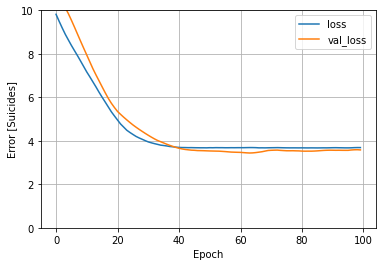

In [18]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Suicides]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [19]:
# collect the results on the test set
test_results = {}

test_results['alcohol_model'] = alcohol_model.evaluate(
    test_features['alcohol_consumption_percapita'],
    test_labels, verbose=0)

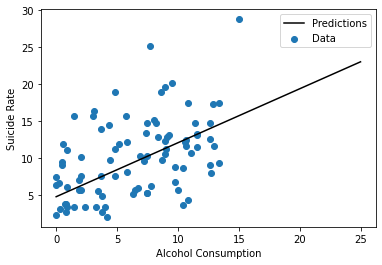

In [20]:
x = tf.linspace(0.0, 25, 26)
y = alcohol_model.predict(x)

def plot_alcohol(x, y):
  plt.scatter(train_features['alcohol_consumption_percapita'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Alcohol Consumption')
  plt.ylabel('Suicide Rate')
  plt.legend()

plot_alcohol(x,y)

In [21]:
# multiple inputs
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

# make predictions with an untrained model
linear_model.predict(train_features[:10])

array([[ 0.235],
       [-0.045],
       [-0.076],
       [ 0.451],
       [-0.137],
       [ 0.271],
       [ 0.049],
       [-0.038],
       [-0.114],
       [-0.606]], dtype=float32)

In [22]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(6, 1) dtype=float32, numpy=
array([[-0.4  ],
       [ 0.893],
       [-0.597],
       [ 0.188],
       [ 0.26 ],
       [-0.494]], dtype=float32)>

In [23]:
# use the same compile and fit calls from single feature
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error',metrics=['mse'])

history = linear_model.fit(
    train_features, train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

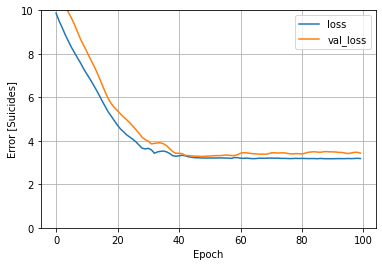

In [24]:
plot_loss(history)

# save the figure for html
plt.savefig('visuals/linear_model_loss.jpg',bbox_inches='tight')

In [25]:
# collect the results on the test set
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [26]:
# DNN regression
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',metrics=['mse'],
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [27]:
# start with one variable (alcohol)
dnn_alcohol_model = build_and_compile_model(alcohol_normalizer)
dnn_alcohol_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 8,516
Trainable params: 8,513
Non-trainable params: 3
_________________________________________________________________


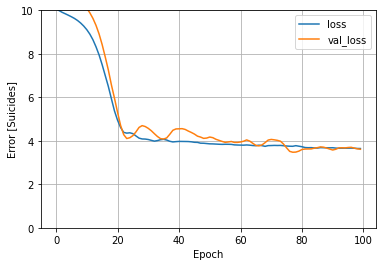

In [28]:
# train the model
history = dnn_alcohol_model.fit(
    train_features['alcohol_consumption_percapita'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)

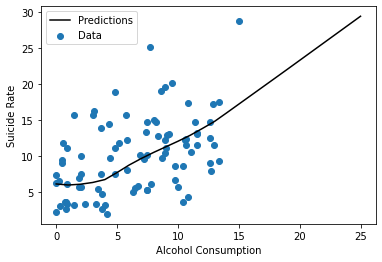

In [29]:
# plot the predictions
x = tf.linspace(0.0, 25, 26)
y = dnn_alcohol_model.predict(x)

plot_alcohol(x, y)

# save the figure for html
plt.savefig('visuals/dnn_alcohol_predictions.jpg',bbox_inches='tight')

In [30]:
# collect the result on the test set
test_results['dnn_alcohol_model'] = dnn_alcohol_model.evaluate(
    test_features['alcohol_consumption_percapita'], test_labels,
    verbose=0)

In [31]:
# full model
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense_6 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 8,846
Trainable params: 8,833
Non-trainable params: 13
_________________________________________________________________


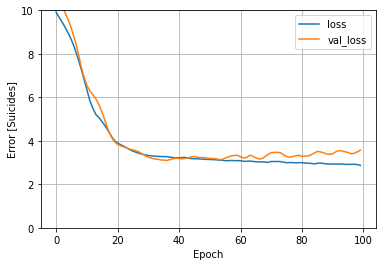

In [32]:
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)

# save the figure for html
plt.savefig('visuals/dnn_model_loss.jpg',bbox_inches='tight')

In [33]:
# collect test set results
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
test_results

{'alcohol_model': [2.883246421813965, 12.407269477844238],
 'linear_model': [2.4700422286987305, 9.481553077697754],
 'dnn_alcohol_model': [3.086653232574463, 13.150995254516602],
 'dnn_model': [2.522892475128174, 11.018324851989746]}

In [34]:
# performance
# check the test-set performance
performance_df = pd.DataFrame(test_results, index=[['Mean Absolute Error','Mean Standard Error']]).T

# save dataframe to csv to be used later
performance_df.to_csv(f'data/performance_table.csv', index=False)

performance_df

,Mean Absolute Error,Mean Standard Error
alcohol_model,2.883246,12.407269
linear_model,2.470042,9.481553
dnn_alcohol_model,3.086653,13.150995
dnn_model,2.522892,11.018325


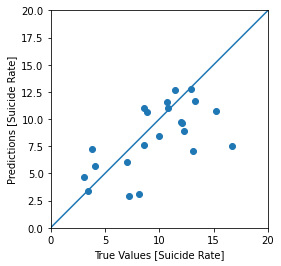

In [35]:
# Make predictions for dnn model
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Suicide Rate]')
plt.ylabel('Predictions [Suicide Rate]')
lims = [0, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# save the figure for html
plt.savefig('visuals/dnn_model_predictions.jpg',bbox_inches='tight')

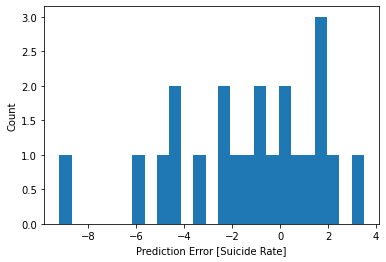

In [36]:
# error distribution for dnn model
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Suicide Rate]')
_ = plt.ylabel('Count')

# save the figure for html
plt.savefig('visuals/dnn_model_error.jpg',bbox_inches='tight')

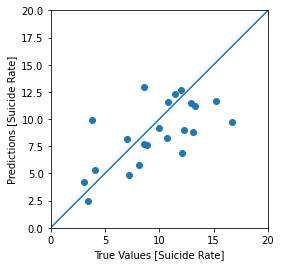

In [37]:
# Make predictions for linear model
test_predictions = linear_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Suicide Rate]')
plt.ylabel('Predictions [Suicide Rate]')
lims = [0, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# save the figure for html
plt.savefig('visuals/linear_model_predictions.jpg',bbox_inches='tight')

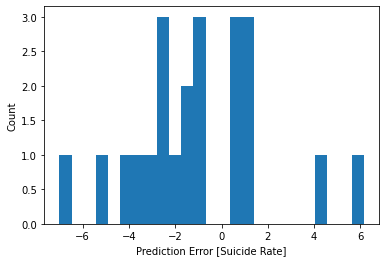

In [38]:
# error distribution for linear model
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Suicide Rate]')
_ = plt.ylabel('Count')

# save the figure for html
plt.savefig('visuals/linear_model_error.jpg',bbox_inches='tight')